Nous importons les différents packages nécéssaires.

In [39]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import math
import time

Initialisation des données : 

In [40]:
dt = 15*60 
nb_intervalles = 672 #nombres d'intervalles de 15 minutes sur 7 jours
temperatures_ext = np.load("Temperatures-Montreal.npy") # donées des températures à Montreal
eta = 0.99 # coefficient relatif à l'isolation
capacite_calorifique = 0.4 * 360 #kWh pour chauffer de 1°c

T_min = 19 #Température minimale du batiment
T_max = 21 #Température maximale du batiment

cout_elec = np.full(nb_intervalles,0.26) #initalisation du cout de l'élec a 0.26 partout
for i in range(7):
    for j in range(96):
        if j < 28 or j>= 88: #réajustement du cout de l'élec a 0.18 entre 22h et 7h
            cout_elec[j+i*96] = 0.18 
            
COPT_reverse = 3.2 #COPT de la pompe quand on refroidi
def COP_normal(T_ext):
    return 3 + 10 * abs(np.tanh(T_ext/100)) * np.tanh(T_ext/100) #Fonction qui décrit le comportement du COP quand on réchauffe


Tache 1:
La temperature doit rester entre 19°c et 21°c et le modele doit minimiser le coût total de l'électricité consommée par la pompe à chaleur

In [41]:
##Initialisation des variables :

T_int = cp.Variable(nb_intervalles)

#puissance qu'on va utiliser pour la pompe à chaleur
P_chauff = cp.Variable(nb_intervalles, nonneg=True) #en mode normal
P_refroid = cp.Variable(nb_intervalles, nonneg=True) #en mode inverse

## Initialisation du tableau de contraintes pour le probleme qui commence à 0:
contraintes_1 = []

#la température du batiment doit rester admissible: 
contraintes_1 += [T_min <= T_int[i] for i in range(nb_intervalles)]
contraintes_1 += [T_int[i] <= T_max for i in range(nb_intervalles)]

for i in range(nb_intervalles - 1):
    
    contraintes_1 += [T_int[i+1] == T_int[i] + (dt/(3600*COP_normal(temperatures_ext[i])))*(P_chauff[i]*COP_normal(temperatures_ext[i]) - (T_int[i] - temperatures_ext[i])) - #FAUT ENLEVER
                       (dt/(3600*COPT_reverse ))*(P_refroid[i]*COPT_reverse  - (T_int[i+1] - temperatures_ext[i]))] ## deuxième terme = perte environnementale

    
    contraintes_1 += [T_int[i + 1] - T_int[i] == (1 - eta) * ( T_int[i]- temperatures_ext[i]) 
                      +(COP_normal(temperatures_ext[i]) * P_chauff * dt * capacite_calorifique) - (COPT_reverse * P_refroid * dt * capacite_calorifique)] #Contrainte perte de chaleur 
    #AJOUTER + (COPrechauffe * Puissance * dt * ε) - (COPrefroid * Puissance * dt * ε)

#Contrainte sur la positivité des puissances et max KW
contraintes_1 += [P_chauff >= 0]
contraintes_1 += [P_refroid >= 0]
contraintes_1 += [P_chauff <= 3.2]
contraintes_1 += [P_refroid <= 3.2]

## Initialisation du cout total :
cost = cp.sum(cout_elec * (P_chauff + P_refroid)) 

start_time1 = time.time()

##Résolution 1 :
problem1 = cp.Problem(cp.Minimize(cost), contraintes_1)
first =problem1.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
temps_calcul1 = time.time() - start_time1

/home/iss25/.local/lib/python3.10/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)


Plot pour tache 1:

1: 
 Puissances normales =  None 
 Puissances reverses =  None 
 Températures internes =  None 
 Cout =  inf 
 Temps de résolution =  25.507481336593628


ValueError: x, y, and format string must not be None

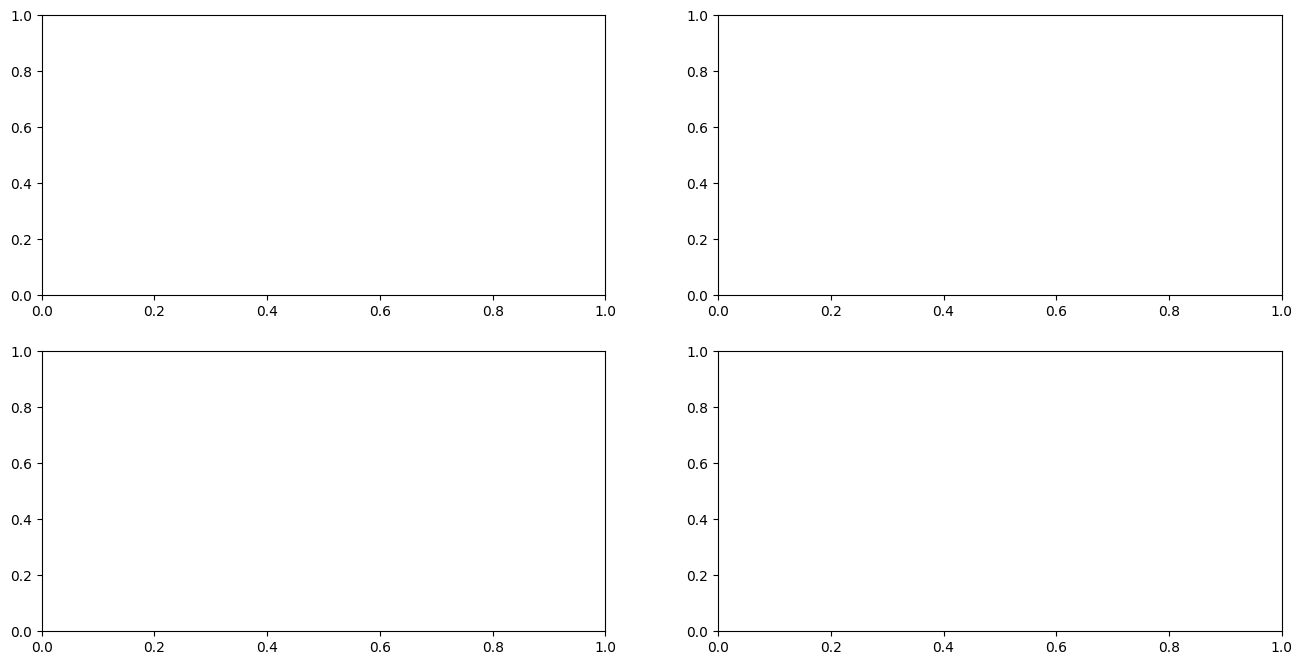

In [42]:
##Récupération des valeurs :

print("1:", "\n","Puissances normales = ", P_chauff.value, "\n", "Puissances reverses = ", P_refroid.value,"\n", "Températures internes = ", T_int.value, "\n",
      "Cout = ", problem1.value,"\n", "Temps de résolution = ", temps_calcul1)


# Graphique de l'évolution des températures
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
x = np.linspace(0, 672, 672)

axs[0][0].plot(x,T_int.value)
axs[0][0].set_title("Période 1 - Évolution des températures")
axs[0][0].set_xlabel("Intervalle de temps")
axs[0][0].set_ylabel("Température (°C)")

# Graphique représentant l'utilisation de la pompe à chaleur

x = np.linspace(0, 672, 672)

axs[1][0].plot(x, P_chauff.value, label="Fonctionnement normal")
axs[1][0].plot(x, P_refroid.value, label="Fonctionnement reverse")
axs[1][0].set_title("Période 1 - Utilisation de la pompe à chaleur")
axs[1][0].set_xlabel("Intervalle de temps")
axs[1][0].set_ylabel("Puissance (kW)")
axs[1][0].legend()

Tache 2: minimiser l'inconfort total en respectant contrainte de budget

Plot pour tache 2:

Tache 3: graphique représentant au mieux cette relation entre budget et inconfort

Plot pour tache 3: